In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from lib.gif import create_gif
from population import *
import cv2
from individual import Individual, Polygon
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
plt.rcParams['figure.facecolor'] = 'white'


Polygon(n_points=4, color=[0.909 0.264 0.444], coords=[[119, 29], [68, 49], [28, 30], [71, 154]])


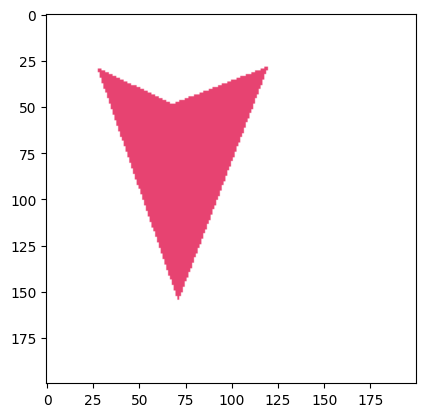

In [3]:
p = Polygon()
print(p)
p.draw()

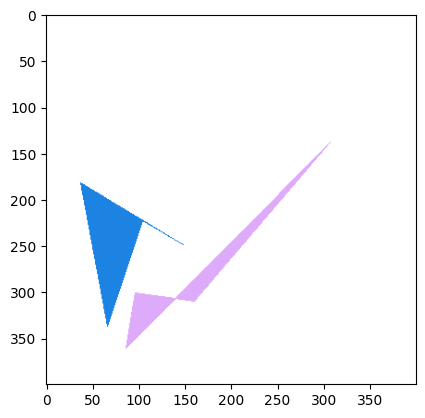

In [4]:
ind = Individual(n_polygons=2, canvas_size=(400, 400, 3), mutate_p=1, add_or_del_p=0.0)
ind.draw()
plt.imshow(ind.get_image())

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

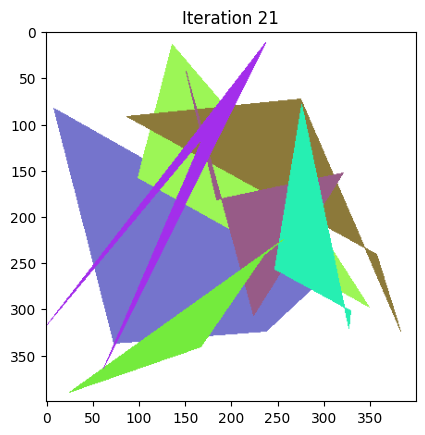

In [6]:
ind = Individual(n_polygons=5, canvas_size=(400, 400, 3), mutate_p=0.5, add_or_del_p=0.1)
# fig = plt.figure(figsize=(10,10))
dir = Path('img/polygon_mutation/')
os.makedirs(dir/'iters', exist_ok=True)
for i in tqdm(range(50)):
    plt.title(f'Iteration {i}')
    ind.mutate()
    ind.draw()
    plt.imshow(ind.img)
    plt.savefig(f"{dir}/iters/polygon_mutation_{i:03}.png", dpi=150, bbox_inches='tight')
    plt.close()

create_gif(src_dir=dir/'iters', fp_out=dir/'mutation.gif')


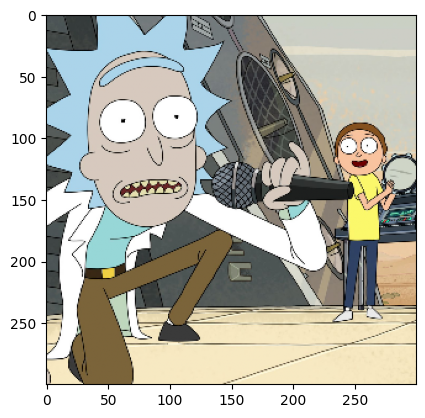

In [5]:
TARGET = plt.imread('../targets/rick.jpg')
TARGET = cv2.resize(TARGET, (300, 300))
TARGET = TARGET / 255
plt.imshow(TARGET)

In [12]:
n_iter = 5000
pop = Population(popsize=100, target=TARGET, add_or_del_p=0.2, n_polygons=20, penalty_rate=5e-5, sample_top_n=0.7, copy_top_perc=0.01)
pop.optimize(n_iter=n_iter, plot=True, show=True, dir_name='rick_polygons', plot_freq=20)

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
from typing import Dict, Any
from joblib import Parallel, delayed
from itertools import product
import pandas as pd
import plotly.express as px

mutation_delta = [0.2] #[0.1, 0.2, 0.3, 0.4]
mutation_prob = [0.3] #[0.1, 0.3, 0.5]
copy_top_perc = [0.01, 0.04, 0.08, 0.15]
sample_top_n = np.arange(0.0, 0.5, 0.1)
n_polygons = range(10, 30, 5)
add_or_del_p = np.arange(0.2, 0.5, 0.1)
results = []

def optimize_with_config(**opt_config) -> Dict[str, Any]:
    pop = Population(target=TARGET, popsize=10, **opt_config)
    pop.optimize(n_iter=20, plot=False)
    return {
        **opt_config,
        'fitness': pop.pop[0].fitness
        }

In [ ]:
param_combinations = list(product(mutation_delta, mutation_prob, copy_top_perc, sample_top_n, n_polygons, add_or_del_p))
result = (Parallel(n_jobs=-1)(delayed(optimize_with_config)(
    mutate_d=mdelta, mutate_p=mprob, copy_top_perc=topp, sample_top_n=topn, n_polygons=n_polys, add_or_del_p=add_del_p
    ) for mdelta, mprob, topp, topn, n_polys, add_del_p in tqdm(param_combinations, total=len(param_combinations)))
)
results_df = pd.DataFrame(result)
results_df.to_parquet('grid_search_results.parquet')
results_df = results_df.sort_values('fitness')
results_df.head()

  0%|          | 0/240 [00:00<?, ?it/s]

In [11]:
results_df.sort_values('fitness')
results_df.head()

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,fitness
0,[0.2],[0.3],"[0.01, 0.04, 0.08, 0.15]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]",0.111311
1,[0.2],[0.3],"[0.01, 0.04, 0.08, 0.15]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]",0.108740
2,[0.2],[0.3],"[0.01, 0.04, 0.08, 0.15]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]",0.118309
3,[0.2],[0.3],"[0.01, 0.04, 0.08, 0.15]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]",0.093748
4,[0.2],[0.3],"[0.01, 0.04, 0.08, 0.15]","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]",0.102006


In [ ]:
px.parallel_coordinates(results_df, color='fitness', labels=['mutation_delta', 'mutation_prob', 'copy_top_perc', 'sample_top_n', 'fitness'])

NameError: name 'results_df' is not defined